In [ ]:
# This tests how we find errors for our calibration program star metallicities, and how we
# find final error bars on our calibration solution coefficients

# created 2018 Jan 14 by E.S.

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import multiprocessing
import scipy
import scipy.stats as stats
from scipy import interpolate
from astropy.modeling.functional_models import Gaussian2D
from astropy.stats import bootstrap
from astropy.utils import NumpyRNGContext
from multiprocessing import Pool

In [2]:
# make some fake data representing the metallicities and errors of stars from the literature

'''
fake_data_1 = {"star_name": ["AA Aql","AO Peg","BR Aqr","CI And","DM Cyg","DO Vir","DX Del","X Ari"],
                "feh_lit": [-1.1,-0.6,-1.29,-1.22,-0.69,-0.43,-0.04,-2.51],
                "feh_layden": [-1.05,-0.9,-1.15,-1.2,-0.45,-0.7,0.0,-2.1],
                "err_feh_lit": [0.3,0.3,0.3,0.4,0.2,0.35,0.3,0.4],
                "err_feh_layden": [0.06,0.06,0.07,0.06,0.07,0.06,0.06,0.07]}

fake_dataset_1 = pd.DataFrame(data=fake_data_1)
'''

'\nfake_data_1 = {"star_name": ["AA Aql","AO Peg","BR Aqr","CI And","DM Cyg","DO Vir","DX Del","X Ari"],\n                "feh_lit": [-1.1,-0.6,-1.29,-1.22,-0.69,-0.43,-0.04,-2.51],\n                "feh_layden": [-1.05,-0.9,-1.15,-1.2,-0.45,-0.7,0.0,-2.1],\n                "err_feh_lit": [0.3,0.3,0.3,0.4,0.2,0.35,0.3,0.4],\n                "err_feh_layden": [0.06,0.06,0.07,0.06,0.07,0.06,0.06,0.07]}\n\nfake_dataset_1 = pd.DataFrame(data=fake_data_1)\n'

In [3]:
# read in actual data

real_data_1 = pickle.load( open( "info.pkl", "rb" ) )

In [4]:
# arrange the data in a way we can use
# N.b. This is NOT fake data; I'm just appropriating the old variable name

fake_data_1 = { "star_name": real_data_1[0]["name_star"],
                "feh_lit": real_data_1[0]["FeH_highres"],
                "feh_layden": real_data_1[0]["FeH_basis"],
                "err_feh_lit": np.zeros(len(real_data_1[0]["FeH_basis"])),
                "err_feh_layden": 0.07*np.ones(len(real_data_1[0]["FeH_basis"]))}

fake_dataset_1 = pd.DataFrame(data=fake_data_1)

In [5]:
# show the points we are working with

'''
plt.errorbar(fake_data_1["feh_layden"], fake_data_1["feh_lit"], 
             yerr=fake_data_1["err_feh_lit"], xerr=fake_data_1["err_feh_layden"], marker="s", linestyle='')
plt.xlabel("Fake Layden 94 Fe/H")
plt.ylabel("Fake Literature Fe/H")
plt.savefig("fake_data.png")
#plt.show()
'''

'\nplt.errorbar(fake_data_1["feh_layden"], fake_data_1["feh_lit"], \n             yerr=fake_data_1["err_feh_lit"], xerr=fake_data_1["err_feh_layden"], marker="s", linestyle=\'\')\nplt.xlabel("Fake Layden 94 Fe/H")\nplt.ylabel("Fake Literature Fe/H")\nplt.savefig("fake_data.png")\n#plt.show()\n'

# Step 1: Find the linear regression line to high_res vs. basis Fe/H values

In [6]:
# Put Fe/H values into a useable form

feh_sample = np.transpose([fake_data_1["feh_layden"],fake_data_1["feh_lit"]])

In [7]:
# Bootstrap

N_samples = int(1e4)

# set RNG for reproducibility
with NumpyRNGContext(1):
    bootresult = bootstrap(feh_sample, N_samples)

In [8]:
# for testing results with different seeds
#bootresult = bootstrap(feh_sample, N_samples)

In [49]:
def cdf_fcn(array_input):
    '''
    Return CDF of an unsorted input array of values
    '''
    
    number_cum_norm = np.divide(np.arange(len(array_input)),len(array_input))
    array_input_sort = np.sort(array_input)
    number_cum_norm = np.divide(np.arange(len(array_input)),len(array_input))
    #array_cdf = np.divide(np.cumsum(array_input_sort),np.cumsum(array_input_sort)[-1])
    
    return array_input_sort, number_cum_norm

In [43]:
test_x

array([-3.672165  , -3.46492644, -3.41546586, ...,  4.49487394,
        4.56756541,  4.79368453])

0.1956254756272534


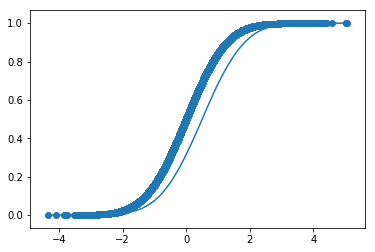

In [44]:
N = int(1e5)
test_array = np.add(np.random.randn(N),np.random.uniform(size=N))
test_x, test_y = cdf_fcn(test_array)

print(np.max(np.abs(np.subtract(test_y,np.sort(norm.cdf(test_array))))))

plt.plot(test_x, test_y)
plt.scatter(test_array,norm.cdf(test_array))
plt.show()

In [53]:
test_array = np.zeros(100)
test_array[-5:] = 33
test_array[-1:] = 100
print(norm.cdf(test_array))
test_x, test_y = cdf_fcn(test_array)

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 1.  1.  1.  1.  1. ]


In [66]:
print(test_y[20])
print(test_y[60])
print(test_y[61])
print(test_y[99])

np.max(test_y[np.where(test_x == 0)]) 
np.max(test_y[np.where(test_x == 33)])
test_y[np.where(test_x == 100)][0]

#np.max(test_y[np.where(test_x == 0)]) == 0.94
#np.max(test_y[np.where(test_x == 33)]) == 0.98
#test_y[np.where(test_x == 100)] == 0.99

0.2
0.6
0.61
0.99
0.94
0.98
0.99


In [61]:
test_x

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,  33.,  33.,  33.,  33.,
       100.])

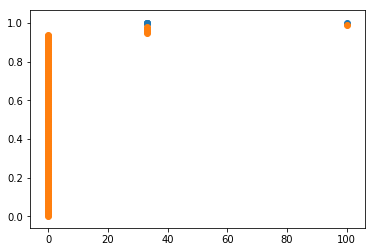

In [62]:
plt.scatter(test_array,norm.cdf(test_array))
plt.scatter(test_x,test_y)
plt.show()

In [10]:
def cdf_gauss(x_range, mu, sig):
    '''
    Returns the CDF of a general Gaussian function for any mu and sig
    '''
    
    x_range_adjust = np.divide(np.subtract(x_range, mu), sig) # rescale x -> x* = (x-mu)/sig
    erf_return = scipy.special.erf(np.divide(x_range_adjust,np.sqrt(2))) # erf(x*/sqrt(2))
    
    return np.multiply(0.5,np.add(1., erf_return)) # (1/2)*(1 + erf(x*/sqrt(2)))

In [11]:
# test of cdf_fcn and cdf_gauss

'''
x_range = np.arange(-5,5,0.01)
mu = -2.
sig = 2

# sample from a gaussian distribution
gaussian_samples = np.random.normal(loc=mu, scale=sig, size=len(x_range))

# test my cdf_fcn
x_range1, y_range1 = cdf_fcn(gaussian_samples)

# test my cdf_gauss fcn
y_range = cdf_gauss(x_range, mu, sig)

plt.plot(x_range, y_range, color='blue')
plt.plot(x_range1, y_range1, color='red')
plt.show()
'''

"\nx_range = np.arange(-5,5,0.01)\nmu = -2.\nsig = 2\n\n# sample from a gaussian distribution\ngaussian_samples = np.random.normal(loc=mu, scale=sig, size=len(x_range))\n\n# test my cdf_fcn\nx_range1, y_range1 = cdf_fcn(gaussian_samples)\n\n# test my cdf_gauss fcn\ny_range = cdf_gauss(x_range, mu, sig)\n\nplt.plot(x_range, y_range, color='blue')\nplt.plot(x_range1, y_range1, color='red')\nplt.show()\n"

In [12]:
# populate the arrays with bootstrap results

m_array = np.nan*np.ones(len(bootresult))
b_array = np.nan*np.ones(len(bootresult))
for boot_n in range(0,len(bootresult)):
    test_fit = np.polyfit(bootresult[boot_n,:,0], bootresult[boot_n,:,1], 1)
    m_array[boot_n] = test_fit[0]
    b_array[boot_n] = test_fit[1]

In [13]:
# show m-b space
'''
plt.scatter(m_array,b_array,s=1)
plt.xlabel("slope m")
plt.ylabel("y-int b")
plt.savefig("line_params.png")
plt.show()
'''

'\nplt.scatter(m_array,b_array,s=1)\nplt.xlabel("slope m")\nplt.ylabel("y-int b")\nplt.savefig("line_params.png")\nplt.show()\n'

In [14]:
# make empirical CDF of m

'''
x_vals, y_vals = cdf_fcn(m_array)

# fit a Gaussian
popt, pcov = scipy.optimize.curve_fit(cdf_gauss, x_vals, y_vals)
print(popt)

plt.plot(x_vals, y_vals)
plt.plot(x_vals, cdf_gauss(x_vals, *popt))
plt.title("CDF of slopes m")
plt.savefig("line_param_cdf_m.png")
plt.show()
'''

'\nx_vals, y_vals = cdf_fcn(m_array)\n\n# fit a Gaussian\npopt, pcov = scipy.optimize.curve_fit(cdf_gauss, x_vals, y_vals)\nprint(popt)\n\nplt.plot(x_vals, y_vals)\nplt.plot(x_vals, cdf_gauss(x_vals, *popt))\nplt.title("CDF of slopes m")\nplt.savefig("line_param_cdf_m.png")\nplt.show()\n'

In [15]:
# make empirical CDF of b

'''
x_vals, y_vals = cdf_fcn(b_array)

# fit a Gaussian
popt, pcov = scipy.optimize.curve_fit(cdf_gauss, x_vals, y_vals)
print(popt)

plt.plot(x_vals, y_vals)
plt.plot(x_vals, cdf_gauss(x_vals, *popt))

plt.plot(x_vals, y_vals)
plt.title("CDF of y-int b")
plt.savefig("line_param_cdf_b.png")
plt.show()
'''

'\nx_vals, y_vals = cdf_fcn(b_array)\n\n# fit a Gaussian\npopt, pcov = scipy.optimize.curve_fit(cdf_gauss, x_vals, y_vals)\nprint(popt)\n\nplt.plot(x_vals, y_vals)\nplt.plot(x_vals, cdf_gauss(x_vals, *popt))\n\nplt.plot(x_vals, y_vals)\nplt.title("CDF of y-int b")\nplt.savefig("line_param_cdf_b.png")\nplt.show()\n'

In [16]:
def make_hist_plot(name_star,feh_mapped_array):

    plt.clf()
    plt.hist(np.ravel(feh_mapped_array), bins = 100)
    plt.title(name_star + "\n" + "std = "+str(np.std(np.ravel(feh_mapped_array))))
    plt.xlabel("Fe/H")
    plt.tight_layout()
    plt.savefig("junk_images/" + name_star + "_hist.pdf")
    plt.close()

In [17]:
def make_cdf_plot(name_star,feh_mapped_array):

    x_vals, y_vals = cdf_fcn(np.ravel(feh_mapped_array))

    # fit a Gaussian
    popt, pcov = scipy.optimize.curve_fit(cdf_gauss, x_vals, y_vals)

    print("Line parameters")
    print(popt)

    xvals_interp = np.arange(x_vals[0], x_vals[-1], 0.001)
    yvals_interp = np.interp(xvals_interp, x_vals, y_vals)

    # find element of value closest to 0.5
    percent_bar = 0.5
    idx = np.abs(yvals_interp - percent_bar).argmin()


    # ---------------------------------------------------------------------------

    # SIGMA DEFINITION 1: FIND MEDIAN AND SIGMA BRACKETS AROUND IT
    # find element of value closest to 1-sigma limit (on low side)
    percent_bar_1sig_low = 0.5 - 0.5*0.682689492
    idx_1sig_low = np.abs(yvals_interp - percent_bar_1sig_low).argmin()
    # find element of value closest to 1-sigma limit (on high side)
    percent_bar_1sig_high = 0.5 + 0.5*0.682689492
    idx_1sig_high = np.abs(yvals_interp - percent_bar_1sig_high).argmin()

    # SIGMA DEFINITION 2: FIND NARROWEST REGION CONTAINING 1-SIGMA WORTH OF POINTS
    shortest_xrange = xvals_interp[-1] - xvals_interp[0]
    shortest_xrange_lower = xvals_interp[0]

    for t in range(0,len(xvals_interp)):
    
        lower_bar_y = yvals_interp[t]
        upper_bar_y = yvals_interp[t] + 0.682689492
    
        # break if the range will go beyond data points
        if (upper_bar_y > 0.99):
            break
    
        idx_1sig_here = t
        idx_1sig_above = np.abs(yvals_interp - upper_bar_y).argmin()
    
        if (np.subtract(xvals_interp[idx_1sig_above],
                        xvals_interp[idx_1sig_here]) < shortest_xrange):
        
            shortest_xrange = xvals_interp[idx_1sig_above] - xvals_interp[idx_1sig_here]
            shortest_xrange_lower = xvals_interp[idx_1sig_here]
            shortest_xrange_upper = xvals_interp[idx_1sig_above]
            shortest_xrange_halfway = 0.5*np.subtract(shortest_xrange_upper,shortest_xrange_lower)+shortest_xrange_lower

    # ---------------------------------------------------------------------------

    # test how gaussian the data is, based on earlier fit
    print("K-S test")
    print(stats.kstest(y_vals, 'norm', args=popt)[0])
    print(stats.kstest(y_vals, 'norm', args=popt)[1])
    
    print("Fe/H at 50 percentile")
    print(xvals_interp[idx])

    print("1-sigma interval")
    print(xvals_interp[idx_1sig_low])
    print(xvals_interp[idx_1sig_high])

    plt.clf()
    plt.plot(x_vals, y_vals)
    plt.plot(x_vals, cdf_gauss(x_vals, *popt), linestyle=":", color="k")
    plt.axvline(xvals_interp[idx], color='blue')
    plt.axvline(xvals_interp[idx_1sig_low], color='blue')
    plt.axvline(xvals_interp[idx_1sig_high], color='blue')
    plt.axvline(shortest_xrange_lower, color='orange')
    plt.axvline(shortest_xrange_upper, color='orange')
    plt.axvline(shortest_xrange_halfway, color='orange')
    plt.xlabel("Fe/H")
    plt.ylabel("CDF")
    plt.title(name_star + "\n"+\
          "Fe/H based on median (blue): "
          + "{:.{}f}".format( xvals_interp[idx], 3) + ", +" + "{:.{}f}".format( np.subtract(xvals_interp[idx_1sig_high],xvals_interp[idx]), 3) 
          + ", -" + "{:.{}f}".format( np.subtract(xvals_interp[idx],xvals_interp[idx_1sig_low]), 3) +"\n"+\
          "Fe/H based on shortest range (orange): "
          + "{:.{}f}".format( shortest_xrange_halfway, 3) + ", +" + "{:.{}f}".format( np.subtract(shortest_xrange_upper,shortest_xrange_halfway), 3) 
          + ", -" + "{:.{}f}".format( np.subtract(shortest_xrange_halfway,shortest_xrange_lower), 3))
    plt.tight_layout()
    plt.savefig("junk_images/" + name_star + "_cdf.pdf")
    plt.close()

In [18]:
# consolidate info, remove extra dimension
name_star = fake_data_1["star_name"][:].values
feh_test = fake_data_1["feh_layden"][:].values
params_array = np.squeeze([[name_star],[feh_test]])

In [20]:
# fyi

#params_array[:,1]

In [21]:
# arrange into a list 

params_list_star_feh = list(np.transpose(params_array))

In [22]:
# fyi

#params_list_star_feh[4][0]

In [23]:
## ## single function for parallel processing

def map_feh_one_star(params_element):
    time_start = time.time()
    feh_mapped_array = np.nan*np.ones(len(m_array)) # initialize array
    
    # get name and Layden Fe/H of star
    name_star = params_element[:][0]
    feh_test = params_element[:][1]
    print("Star:")
    print(name_star)
    print("Layden Fe/H:")
    print(feh_test)
    
    for sample_num in range(0,len(m_array)):
    
        feh_mapped_1sample = m_array[sample_num]*feh_test + b_array[sample_num]
        feh_mapped_array[sample_num] = feh_mapped_1sample
        
    # take one basis set Fe/H (integral over a Gaussian) and find what the mapped value should be 
    N = 100 # number of samples to take within the Gaussian error around Layden's Fe/H value
    gaussian_spread = 0.07
    layden_feh = feh_test # this is the discrete value
    feh_mapped_array = np.nan*np.ones((len(m_array),N)) # N_m_samples x N_Layden_samples

    # loop over each sample within the Gaussian around Layden's Fe/H
    for integal_piece in range(0,N):
    
        # set the offset (note mu=0; this is a relative offset)
        offset = np.random.normal(loc = 0.0, scale = gaussian_spread)
    
        # loop over all (m,b) combinations found further above
        for sample_num in range(0,len(m_array)):
    
            feh_mapped_1sample = m_array[sample_num]*layden_feh*(1. + offset) + b_array[sample_num]
            feh_mapped_array[sample_num][integal_piece] = feh_mapped_1sample
    
    # make plots
    make_hist_plot(name_star,feh_mapped_array)
    make_cdf_plot(name_star,feh_mapped_array)

    print("Elapsed time:")
    print(str(time.time() - time_start))
    print("--------------------------")

In [28]:
# parallel process

#map_feh = map_feh_one_star()
ncpu = multiprocessing.cpu_count()
pool = Pool(ncpu)
outdat = pool.map(map_feh_one_star,params_list_star_feh)
pool.close()

Star:
Star:
Star:
AV Peg
Star:
SW And
Layden Fe/H:
CN Lyr
Layden Fe/H:
VY Ser
Layden Fe/H:
-0.26
Layden Fe/H:
-0.14
-0.38
-1.82
Line parameters
[-0.04551422  0.04848954]
K-S test
0.925928903240767
Line parameters
[-0.16432131  0.04626067]
K-S test
0.0
Fe/H at 50 percentile
-0.045252289846144156
1-sigma interval
-0.0952522898461442
0.001747710153855886
0.9998088961352931
Line parameters
[-0.28316542  0.04613216]
K-S test
0.0
0.9999999995825217
Fe/H at 50 percentile
-0.16375809458245372
1-sigma interval
-0.21175809458245376
-0.11875809458245368
0.0
Fe/H at 50 percentile
-0.2835050441225995
1-sigma interval
-0.32950504412259957
-0.23750504412259948
Line parameters
[-1.70339791  0.1344584 ]
K-S test
1.0
Elapsed time:
8.760661125183105
--------------------------
Star:
AR Per
Layden Fe/H:
0.0
-0.43
Fe/H at 50 percentile
-1.7033008349412864
1-sigma interval
-1.8413008349412712
-1.5683008349413012
Elapsed time:
9.098933935165405
--------------------------
Star:
DM Cyg
Layden Fe/H:
-0.14
Elapse

Process ForkPoolWorker-8:


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/Users/nyumbani/anaconda3/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/Users/nyumbani/anaconda3/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/nyumbani/anaconda3/lib/python3.5/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))


# Step 2: Find the remapping of literature metallicities, with errors

# Step 3: Find the calibration coefficients (a,b,c,d) with errors